# Exercises
file name: anomaly_detection.py or anomaly_detection.ipynb

#### Discrete data + probability
Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

#### Time series + EMA
Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

#### Clustering - DBSCAN
Use dbscan to detect anomalies in other products from the customers dataset.

Use dbscan to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

# %%%%%%%%%%%%%%%%%

# Anomaly Detection of Discrete Data using Probability
## Discrete data + probability

### Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline
from ipaddress import ip_address
import re
import json
from urllib.request import urlopen
import ipinfo

#### Wrangle Data
##### Acquire

sample data rows:

2018-01-26 09:55:03 / 1 8 97.105.19.61

2018-01-26 10:00:02 javascript-i/introduction/working-with-data-types-operators-and-variables 6 22 97.105.19.61

2018-01-26 10:00:49 javascript-i/introduction/variables 6 22 97.105.19.61

In [2]:
colnames=['date', 'time', 'stuff', 'id', 'cohort', 'ip_address']
# df = pd.read_csv('./access.log',   # New data for Bayes cohort       
df = pd.read_csv('./anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=' ',
#                  sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
#                  usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [3]:
df.head().append(df.tail())

,date,time,stuff,id,cohort,ip_address
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
233523,2019-04-02,11:10:19,java-ii/annotations,329,29.0,97.105.19.58
233524,2019-04-02,11:11:18,javascript-i/introduction/working-with-data-ty...,384,31.0,97.105.19.58
233525,2019-04-02,11:11:23,javascript-i,373,31.0,97.105.19.58
233526,2019-04-02,11:11:25,javascript-i/introduction/working-with-data-ty...,376,31.0,97.105.19.58
233527,2019-04-02,11:11:29,javascript-i/introduction/working-with-data-ty...,373,31.0,97.105.19.58


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233528 entries, 0 to 233527
Data columns (total 6 columns):
date          233528 non-null object
time          233528 non-null object
stuff         233528 non-null object
id            233528 non-null int64
cohort        219070 non-null float64
ip_address    233528 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 10.7+ MB


In [5]:
df.isna().sum()

date              0
time              0
stuff             0
id                0
cohort        14458
ip_address        0
dtype: int64

Fill missing cohort numbers with 0.

In [6]:
df.cohort.fillna(0, inplace=True)
df.isna().sum()

date          0
time          0
stuff         0
id            0
cohort        0
ip_address    0
dtype: int64

In [7]:
df.shape

(233528, 6)

In [8]:
df.dtypes

date           object
time           object
stuff          object
id              int64
cohort        float64
ip_address     object
dtype: object

##### Make the access date the index
Create a timestamp for the index.

In [9]:
df['timestamp'] = df.date + ' ' + df.time
df.timestamp = pd.to_datetime(df['timestamp'])
df.head()

,date,time,stuff,id,cohort,ip_address,timestamp
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [10]:
df = df.set_index('timestamp')
df.head()

,date,time,stuff,id,cohort,ip_address
timestamp,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


##### Clean up text

Replace the request paths that have only / with home_page.

In [11]:
df.replace(regex=r'^/$', value='home_page', inplace=True)

In [12]:
maxcount = 0
for i, command in enumerate(df.stuff):
    if len(command.split('/')) > maxcount:
        maxcount = len(command.split('/'))
        print('maxcount: ', maxcount)
        print(command)
print('final maxcount is ', maxcount)

maxcount:  1
home_page
maxcount:  2
java-ii/object-oriented-programming
maxcount:  3
javascript-i/introduction/working-with-data-types-operators-and-variables
maxcount:  4
appendix/further-reading/javascript/hoisting.html
maxcount:  6
content/laravel/intro/gitbook/images/favicon.ico
maxcount:  7
content/appendix/postwork/basic_challenges/gitbook/images/favicon.ico
maxcount:  8
cohorts/%7Bid%7D/grades.csvhttp://tools.codeup.com/cohorts/26/grades.csv
final maxcount is  8


This row is clearly an error...

In [13]:
df[df.stuff == 'cohorts/%7Bid%7D/grades.csvhttp://tools.codeup.com/cohorts/26/grades.csv']

,date,time,stuff,id,cohort,ip_address
timestamp,,,,,,
2019-01-11 11:51:19,2019-01-11,11:51:19,cohorts/%7Bid%7D/grades.csvhttp://tools.codeup...,64,28.0,70.118.8.243


In [14]:
df = df[df.stuff != 'cohorts/%7Bid%7D/grades.csvhttp://tools.codeup.com/cohorts/26/grades.csv']
df[df.stuff == 'cohorts/%7Bid%7D/grades.csvhttp://tools.codeup.com/cohorts/26/grades.csv']

,date,time,stuff,id,cohort,ip_address
timestamp,,,,,,


In [15]:
maxcount = 0
for i, command in enumerate(df.stuff):
    if len(command.split('/')) > maxcount:
        maxcount = len(command.split('/'))
        print('maxcount: ', maxcount)
        print(command)
print('final maxcount is ', maxcount)

maxcount:  1
home_page
maxcount:  2
java-ii/object-oriented-programming
maxcount:  3
javascript-i/introduction/working-with-data-types-operators-and-variables
maxcount:  4
appendix/further-reading/javascript/hoisting.html
maxcount:  6
content/laravel/intro/gitbook/images/favicon.ico
maxcount:  7
content/appendix/postwork/basic_challenges/gitbook/images/favicon.ico
final maxcount is  7


Take off the page number stuff from the request paths...

In [16]:
df['stuff'] = df.stuff.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,date,time,stuff,id,cohort,ip_address
timestamp,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,home_page,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


Split the request path into sections. Each section will get its own row.

In [17]:
s = df['stuff'].str.split('/').apply(pd.Series, 1).stack()

s.index = s.index.droplevel(-1) # to line up with df's index

s.name = 'stuff' # needs a name to join

s

timestamp
2018-01-26 09:55:03                                          home_page
2018-01-26 09:56:02                                            java-ii
2018-01-26 09:56:05                                            java-ii
2018-01-26 09:56:05                        object-oriented-programming
2018-01-26 09:56:06                                             slides
2018-01-26 09:56:06                        object_oriented_programming
2018-01-26 09:56:24                                       javascript-i
2018-01-26 09:56:24                                       conditionals
2018-01-26 09:56:41                                       javascript-i
2018-01-26 09:56:41                                              loops
2018-01-26 09:56:46                                       javascript-i
2018-01-26 09:56:46                                       conditionals
2018-01-26 09:56:48                                       javascript-i
2018-01-26 09:56:48                                          functi

Drop the 'stuff' column before the join.

In [18]:
df_no_stuff = df.drop(columns = 'stuff')

In [19]:
df_split = df_no_stuff.join(s.apply(lambda x: pd.Series(x.split('/'))))

In [20]:
df_split.head(2)

,date,time,id,cohort,ip_address,0
timestamp,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,1,8.0,97.105.19.61,home_page
2018-01-26 09:56:02,2018-01-26,09:56:02,1,8.0,97.105.19.61,java-ii


In [21]:
df_split.rename(columns={0:'stuff'}, inplace=True)
df_split.head(20)

,date,time,id,cohort,ip_address,stuff
timestamp,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,1,8.0,97.105.19.61,home_page
2018-01-26 09:56:02,2018-01-26,09:56:02,1,8.0,97.105.19.61,java-ii
2018-01-26 09:56:05,2018-01-26,09:56:05,1,8.0,97.105.19.61,java-ii
2018-01-26 09:56:05,2018-01-26,09:56:05,1,8.0,97.105.19.61,object-oriented-programming
2018-01-26 09:56:06,2018-01-26,09:56:06,1,8.0,97.105.19.61,slides
2018-01-26 09:56:06,2018-01-26,09:56:06,1,8.0,97.105.19.61,object_oriented_programming
2018-01-26 09:56:24,2018-01-26,09:56:24,2,22.0,97.105.19.61,javascript-i
2018-01-26 09:56:24,2018-01-26,09:56:24,2,22.0,97.105.19.61,conditionals
2018-01-26 09:56:41,2018-01-26,09:56:41,2,22.0,97.105.19.61,javascript-i


Save df_split for possible later use. Back to exploring df...

Tried to use a function, ipaddress.ip_address, that is supposed to return the country and other info about the ip address.

In [22]:
from ipaddress import ip_address

In [23]:
ip_address(df.ip_address)
# I can't figure out what this error message means...

ValueError: timestamp
2018-01-26 09:55:03    97.105.19.61
2018-01-26 09:56:02    97.105.19.61
2018-01-26 09:56:05    97.105.19.61
2018-01-26 09:56:06    97.105.19.61
2018-01-26 09:56:24    97.105.19.61
2018-01-26 09:56:41    97.105.19.61
2018-01-26 09:56:46    97.105.19.61
2018-01-26 09:56:48    97.105.19.61
2018-01-26 09:56:59    97.105.19.61
2018-01-26 09:58:26    97.105.19.61
2018-01-26 09:59:22    97.105.19.61
2018-01-26 10:00:02    97.105.19.61
2018-01-26 10:00:37    97.105.19.61
2018-01-26 10:00:39    97.105.19.61
2018-01-26 10:00:44    97.105.19.61
2018-01-26 10:00:49    97.105.19.61
2018-01-26 10:00:57    97.105.19.61
2018-01-26 10:01:12    97.105.19.61
2018-01-26 10:02:02    97.105.19.61
2018-01-26 10:02:21    97.105.19.61
2018-01-26 10:02:42    97.105.19.61
2018-01-26 10:05:26    97.105.19.61
2018-01-26 10:05:36    97.105.19.61
2018-01-26 10:08:22    97.105.19.61
2018-01-26 10:08:34    97.105.19.61
2018-01-26 10:08:45    97.105.19.61
2018-01-26 10:08:55    97.105.19.61
2018-01-26 10:09:15    97.105.19.61
2018-01-26 10:09:24    97.105.19.61
2018-01-26 10:10:16    97.105.19.61
                           ...     
2019-04-02 11:03:47    97.105.19.58
2019-04-02 11:04:02    97.105.19.58
2019-04-02 11:04:13    97.105.19.58
2019-04-02 11:04:29    97.105.19.58
2019-04-02 11:04:33    97.105.19.58
2019-04-02 11:05:15    97.105.19.58
2019-04-02 11:05:17    97.105.19.58
2019-04-02 11:05:20    97.105.19.58
2019-04-02 11:05:27    97.105.19.58
2019-04-02 11:06:01    97.105.19.58
2019-04-02 11:06:51    97.105.19.58
2019-04-02 11:06:54    97.105.19.58
2019-04-02 11:07:35    97.105.19.58
2019-04-02 11:07:39    97.105.19.58
2019-04-02 11:08:24    97.105.19.58
2019-04-02 11:08:53    97.105.19.58
2019-04-02 11:08:56    97.105.19.58
2019-04-02 11:08:58    97.105.19.58
2019-04-02 11:09:00    97.105.19.58
2019-04-02 11:09:21    97.105.19.58
2019-04-02 11:09:32    97.105.19.58
2019-04-02 11:09:58    97.105.19.58
2019-04-02 11:10:00    97.105.19.58
2019-04-02 11:10:13    97.105.19.58
2019-04-02 11:10:17    97.105.19.58
2019-04-02 11:10:19    97.105.19.58
2019-04-02 11:11:18    97.105.19.58
2019-04-02 11:11:23    97.105.19.58
2019-04-02 11:11:25    97.105.19.58
2019-04-02 11:11:29    97.105.19.58
Name: ip_address, Length: 233527, dtype: object does not appear to be an IPv4 or IPv6 address

In [24]:
count = 0
try:
    network = ip_address(df.ip_address)
except ValueError:
    count += 1
    print('address/netmask is invalid:', count)

address/netmask is invalid: 1


In [25]:
df.ip_address.value_counts()

97.105.19.58       105645
97.105.19.61        61662
192.171.117.210      5966
173.174.211.206      1019
66.69.62.219          934
72.181.104.64         865
216.1.153.162         790
67.11.239.2           749
66.69.108.117         666
170.248.173.245       661
67.10.161.55          651
70.118.8.243          614
70.121.163.5          565
76.185.182.91         564
76.204.31.63          549
24.243.8.81           539
72.191.50.176         523
173.173.113.51        512
173.174.253.193       506
108.65.244.91         506
170.248.173.247       467
104.53.201.99         447
68.206.106.64         446
76.185.131.226        432
104.53.202.214        429
72.181.110.80         420
70.123.231.211        417
173.175.122.123       406
67.11.134.242         405
99.98.36.168          391
                    ...  
172.58.109.37           1
107.77.100.89           1
64.157.241.246          1
99.203.154.116          1
71.40.247.91            1
64.132.225.203          1
172.56.15.6             1
173.174.136.

This is where I'm using ipino to try to read the ipaddress. It works when I use the default that tells me the stats on MY ip address.

In [26]:
# import re
# import json
# from urllib.request import urlopen

url = 'http://ipinfo.io/json'
response = urlopen(url)
data = json.load(response)

IP=data['ip']
org=data['org']
loc=data['loc']
city = data['city']
country=data['country']
region=data['region']

print('Your IP detail\n ')
print('IP : {4} \nRegion : {1} \nCountry : {2} \nCity : {3} \nLoc : {5} \nOrg : {0}'.format(org,region,country,city,IP,loc))

Your IP detail
 
IP : 72.181.113.170 
Region : Texas 
Country : US 
City : San Antonio 
Loc : 29.4229,-98.5260 
Org : AS11427 Charter Communications Inc


In [27]:
# import re
# import json
# from urllib.request import urlopen

url = 'http://ipinfo.io/json'
ip='95.31.18.119'
response = urlopen(url)
data = json.load(response)

IP=data['ip']
org=data['org']
loc=data['loc']
city = data['city']
country=data['country']
region=data['region']

print('Your IP detail\n ')
print('IP : {4} \nRegion : {1} \nCountry : {2} \nCity : {3} \nLoc : {5} \nOrg : {0}'.format(org,region,country,city,IP,loc))

Your IP detail
 
IP : 72.181.113.170 
Region : Texas 
Country : US 
City : San Antonio 
Loc : 29.4229,-98.5260 
Org : AS11427 Charter Communications Inc


I couldn't figure out how to pass the ipaddress as an argument, so I found this code, but couldn't figure out how to make it work... 

In [28]:
# import ipinfo
access_token = '123456789abc'
handler = ipinfo.getHandler(access_token)
ip_address = '216.239.36.21'
details = handler.getDetails(ip_address)
details.city
details.loc

HTTPError: 403 Client Error: Forbidden for url: https://ipinfo.io/216.239.36.21

# import file with cohort info

In [29]:
cohorts = pd.read_csv('./cohort_data.csv')     
cohorts.set_index('id', inplace=True)
cohorts

FileNotFoundError: [Errno 2] File b'./cohort_data.csv' does not exist: b'./cohort_data.csv'

Count number of unique values.

In [30]:
df.nunique()

date            432
time          55696
stuff           998
id              398
cohort           27
ip_address     1731
dtype: int64

In [31]:
df.describe()

,id,cohort
count,233527.000000,233527.000000
mean,191.156149,21.687788
std,111.150132,7.963288
min,1.000000,0.000000
25%,107.000000,22.000000
50%,202.000000,24.000000
75%,277.000000,26.000000
max,398.000000,31.000000


In [32]:
df.status.value_counts()

AttributeError: 'DataFrame' object has no attribute 'status'

Filtered the dataframe down to only cohort == 24.

In [33]:
df_24 = df[df['cohort'] == 24]

Creating a new dataframe with only ip_address and counts.

In [34]:
df_24 = df_24['ip_address'].value_counts().reset_index()
df_24.columns = ['ip_address', 'count']

In [35]:
df_24.tail(257)

,ip_address,count
0,97.105.19.58,16256
1,97.105.19.61,10218
2,192.171.117.210,1129
3,72.181.104.64,599
4,170.248.173.245,451
5,68.206.106.64,446
6,104.53.202.214,429
7,99.158.248.205,362
8,72.191.31.35,339
9,67.11.175.66,320


### Detecting Anomalies in Discrete Variables

Finding anomalies in already existing data

We can see easily some anomalies around IP addresses --- that's from the curriculum... I'm not seeing any anomalies...

In [36]:
df.rename(columns={'ip_address':'ip'}, inplace=True)
df.head(20)

,date,time,stuff,id,cohort,ip
timestamp,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,home_page,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
2018-01-26 09:56:41,2018-01-26,09:56:41,javascript-i/loops,2,22.0,97.105.19.61
2018-01-26 09:56:46,2018-01-26,09:56:46,javascript-i/conditionals,3,22.0,97.105.19.61
2018-01-26 09:56:48,2018-01-26,09:56:48,javascript-i/functions,3,22.0,97.105.19.61
2018-01-26 09:56:59,2018-01-26,09:56:59,javascript-i/loops,2,22.0,97.105.19.61


Creating a dataframe with probabilities that each ip address will be used.

In [37]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]

,ip,ip_count,ip_proba
3,173.174.211.206,1019,0.004364
4,66.69.62.219,934,0.004000
5,72.181.104.64,865,0.003704
6,216.1.153.162,790,0.003383
7,67.11.239.2,749,0.003207
8,66.69.108.117,666,0.002852
9,170.248.173.245,661,0.002831
10,67.10.161.55,651,0.002788
11,70.118.8.243,614,0.002629
12,70.121.163.5,565,0.002419


Only interested in the low probability ip addresses. Had to weed down to ip_df.ip_proba < 0.000005 to weed down the count significantly. That gave 256 rows.

In [38]:
sm_chance = ip_df[ip_df.ip_proba < 0.000005]
sm_chance.shape

(256, 3)

My graph is very pretty, but not at all meaningful.

256
                   ip  ip_count  ip_proba
1721    107.77.197.78         1  0.000004
1722    64.250.227.83         1  0.000004
1723  173.239.198.246         1  0.000004
1724    107.77.222.41         1  0.000004
1725   107.77.219.202         1  0.000004
1726  205.251.150.234         1  0.000004
1727   107.77.222.200         1  0.000004
1728    72.128.131.66         1  0.000004
1729   104.184.220.38         1  0.000004
1730     99.203.26.14         1  0.000004


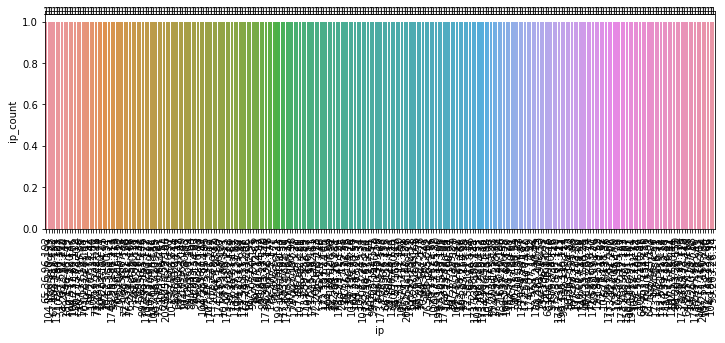

In [39]:
print(len(sm_chance))

print(sm_chance.tail(10))


plt.figure(figsize=(12, 4))
splot = sns.barplot(data=sm_chance, x = 'ip', y = 'ip_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives
##### Establish baseline

In [40]:
df.columns

Index(['date', 'time', 'stuff', 'id', 'cohort', 'ip'], dtype='object')

Dropping date and time and selecting a range of dates.

In [41]:
train = df['2018-01-26 09:55:03':'2019-01-26 09:55:03'][['stuff', 'id', 'cohort', 'ip']]

##### Compute probabilities based on train sample

In [42]:
ip_df = pd.DataFrame(train.ip.value_counts(dropna=False)/train.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})

##### Merge probabilities with all data (train + new data)
- Where the ip address is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

In [43]:
df = df.reset_index().merge(ip_df, on=['ip'], how='left').fillna(value=0).set_index('timestamp')
df.ip.value_counts()

97.105.19.58       105645
97.105.19.61        61662
192.171.117.210      5966
173.174.211.206      1019
66.69.62.219          934
72.181.104.64         865
216.1.153.162         790
67.11.239.2           749
66.69.108.117         666
170.248.173.245       661
67.10.161.55          651
70.118.8.243          614
70.121.163.5          565
76.185.182.91         564
76.204.31.63          549
24.243.8.81           539
72.191.50.176         523
173.173.113.51        512
173.174.253.193       506
108.65.244.91         506
170.248.173.247       467
104.53.201.99         447
68.206.106.64         446
76.185.131.226        432
104.53.202.214        429
72.181.110.80         420
70.123.231.211        417
173.175.122.123       406
67.11.134.242         405
99.98.36.168          391
                    ...  
172.58.109.37           1
107.77.100.89           1
64.157.241.246          1
99.203.154.116          1
71.40.247.91            1
64.132.225.203          1
172.56.15.6             1
173.174.136.

### Conditional Probabilities: probabilities using 2 discrete variables
##### Probability of Status given IP Address:
If we are looking for an unexpected status (like authentication failure) from a known/common IP address.

In [44]:
train.columns

Index(['stuff', 'id', 'cohort', 'ip'], dtype='object')

In [45]:
ip_probs = train.groupby('ip').size().div(len(df))

status_given_ip = pd.DataFrame(train.groupby(['ip', 'cohort']).\
                               size().div(len(train)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='ip').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_ip'})
                              )

In [46]:
ip_status_count = pd.DataFrame(train.groupby(['ip', 'cohort'])['stuff'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'stuff': 'ip_status_count'}))


ip_status = status_given_ip.merge(ip_status_count)
ip_status.head()

,ip,cohort,proba_status_given_ip,ip_status_count
0,100.35.67.162,21.0,1.264283,11
1,104.1.46.153,23.0,1.264283,11
2,104.12.206.124,0.0,1.264283,42
3,104.129.18.241,25.0,1.264283,3
4,104.129.196.183,22.0,1.264283,2


##### Add these probabilities to original events to detect anomalous events

In [47]:
df = df.reset_index().merge(ip_status, on=['ip', 'cohort'], how='left').fillna(value=0).set_index('timestamp')

In [48]:
df.head(2)

,date,time,stuff,id,cohort,ip,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,home_page,1,8.0,97.105.19.61,0.33383,0.020831,1016.0
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,0.33383,0.020831,1016.0


In [49]:
df.sort_values(by=['proba_status_given_ip'], ascending=False)

,date,time,stuff,id,cohort,ip,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2018-02-22 19:59:48,2018-02-22,19:59:48,javascript-i/functions,44,22.0,76.214.156.42,0.000655,1.264283,121.0
2018-07-25 18:31:18,2018-07-25,18:31:18,javascript-ii/npm,223,25.0,72.190.161.136,0.002084,1.264283,385.0
2018-07-25 18:21:35,2018-07-25,18:21:35,html-css/css-i/introduction,223,25.0,72.190.161.136,0.002084,1.264283,385.0
2018-07-25 18:21:09,2018-07-25,18:21:09,html-css/css-i,223,25.0,72.190.161.136,0.002084,1.264283,385.0
2018-07-25 18:21:05,2018-07-25,18:21:05,toc,223,25.0,72.190.161.136,0.002084,1.264283,385.0
2018-07-25 18:11:09,2018-07-25,18:11:09,slides/control_statements_and_loops,196,24.0,70.125.144.209,0.000060,1.264283,11.0
2018-07-25 17:51:37,2018-07-25,17:51:37,slides/syntax_types_and_variables,196,24.0,70.125.144.209,0.000060,1.264283,11.0
2018-07-25 17:51:29,2018-07-25,17:51:29,java-i/syntax-types-and-variables,196,24.0,70.125.144.209,0.000060,1.264283,11.0
2018-07-25 17:49:32,2018-07-25,17:49:32,home_page,196,24.0,70.125.144.209,0.000060,1.264283,11.0


In [50]:
(df['proba_status_given_ip'] > 1.26).sum()

45712

In [51]:
sm_proba = df[df.proba_status_given_ip > 1.26]
print(sm_proba.shape)
sm_proba.head()

(45712, 9)


,date,time,stuff,id,cohort,ip,ip_proba,proba_status_given_ip,ip_status_count
timestamp,,,,,,,,,
2018-01-26 10:59:02,2018-01-26,10:59:02,index.html,21,16.0,71.137.146.71,0.000195,1.264283,36.0
2018-01-26 10:59:06,2018-01-26,10:59:06,java-i,21,16.0,71.137.146.71,0.000195,1.264283,36.0
2018-01-26 12:20:36,2018-01-26,12:20:36,javascript-i/javascript-with-html,34,22.0,209.205.123.242,0.000027,1.264283,5.0
2018-01-26 12:20:41,2018-01-26,12:20:41,javascript-i/functions,34,22.0,209.205.123.242,0.000027,1.264283,5.0
2018-01-26 16:00:29,2018-01-26,16:00:29,javascript-i/introduction/working-with-data-ty...,34,22.0,209.205.123.242,0.000027,1.264283,5.0


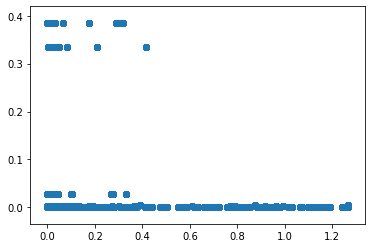

In [52]:
plt.scatter(df.proba_status_given_ip, df.ip_proba)

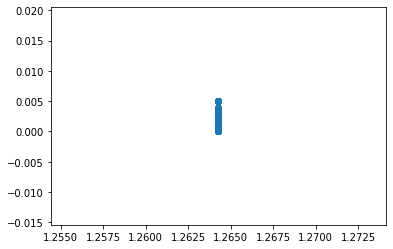

In [53]:
plt.scatter(sm_proba.proba_status_given_ip, sm_proba.ip_proba)

# Detecting Anomalies of Continuous Variables with Time Series Using Statistical Methods

# *Pick a cohort and run this time series analysis on it*
## Time series + EMA
### Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.



### Statistical Methods
- Flag the data points that deviate from the expected, based on the statistical properties, such as mean, median, mode, and quantiles.

- You could define an anomalous data point as one that deviates by a certain standard deviation from the mean.

- You could use a simple or exponential moving average to smooth short-term fluctuations and highlight long-term ones.

- This method is challenging with really noisy data.

### Anomalies in the amount of data consumed over time

In [54]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numpy import linspace, loadtxt, ones, convolve
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd
import collections
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
# style.use('fivethirtyeight')
%matplotlib inline

def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

#### Wrangle Data
##### Acquire

In [55]:
colnames=['date', 'time', 'stuff', 'id', 'cohort', 'ip_address']
df = pd.read_csv('./anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=' ',
                 na_values='"-"'
)

In [56]:
df.head()

,date,time,stuff,id,cohort,ip_address
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [57]:
df.isna().sum()

date              0
time              0
stuff             0
id                0
cohort        14458
ip_address        0
dtype: int64

In [58]:
df.cohort.fillna(0, inplace=True)

In [59]:
df.isna().sum()

date          0
time          0
stuff         0
id            0
cohort        0
ip_address    0
dtype: int64

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233528 entries, 0 to 233527
Data columns (total 6 columns):
date          233528 non-null object
time          233528 non-null object
stuff         233528 non-null object
id            233528 non-null int64
cohort        233528 non-null float64
ip_address    233528 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 10.7+ MB


##### Parse Datetime

In [61]:
df.head()

,date,time,stuff,id,cohort,ip_address
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [62]:
df['timestamp'] = df.date + ' ' + df.time
df.timestamp = pd.to_datetime(df['timestamp'])
df.head()

,date,time,stuff,id,cohort,ip_address,timestamp
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,2018-01-26 09:56:24


In [63]:
df = df.set_index('timestamp')
df.head()

,date,time,stuff,id,cohort,ip_address
timestamp,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


##### Clean up text

In [64]:
df.replace(regex=r'^/$', value='home_page', inplace=True) 

In [65]:
maxcount = 0
for i, command in enumerate(df.stuff):
    if len(command.split('/')) > maxcount:
        maxcount = len(command.split('/'))
        print('maxcount: ', maxcount)
        print(command)
print('final maxcount is ', maxcount)

maxcount:  1
home_page
maxcount:  2
java-ii/object-oriented-programming
maxcount:  3
javascript-i/introduction/working-with-data-types-operators-and-variables
maxcount:  4
appendix/further-reading/javascript/hoisting.html
maxcount:  6
content/laravel/intro/gitbook/images/favicon.ico
maxcount:  7
content/appendix/postwork/basic_challenges/gitbook/images/favicon.ico
maxcount:  8
cohorts/%7Bid%7D/grades.csvhttp://tools.codeup.com/cohorts/26/grades.csv
final maxcount is  8


In [66]:
df[df.stuff == 'cohorts/%7Bid%7D/grades.csvhttp://tools.codeup.com/cohorts/26/grades.csv']

,date,time,stuff,id,cohort,ip_address
timestamp,,,,,,
2019-01-11 11:51:19,2019-01-11,11:51:19,cohorts/%7Bid%7D/grades.csvhttp://tools.codeup...,64,28.0,70.118.8.243


In [67]:
df = df[df.stuff != 'cohorts/%7Bid%7D/grades.csvhttp://tools.codeup.com/cohorts/26/grades.csv']
df[df.stuff == 'cohorts/%7Bid%7D/grades.csvhttp://tools.codeup.com/cohorts/26/grades.csv']

,date,time,stuff,id,cohort,ip_address
timestamp,,,,,,


In [68]:
maxcount = 0
for i, command in enumerate(df.stuff):
    if len(command.split('/')) > maxcount:
        maxcount = len(command.split('/'))
        print('maxcount: ', maxcount)
        print(command)
print('final maxcount is ', maxcount)

maxcount:  1
home_page
maxcount:  2
java-ii/object-oriented-programming
maxcount:  3
javascript-i/introduction/working-with-data-types-operators-and-variables
maxcount:  4
appendix/further-reading/javascript/hoisting.html
maxcount:  6
content/laravel/intro/gitbook/images/favicon.ico
maxcount:  7
content/appendix/postwork/basic_challenges/gitbook/images/favicon.ico
final maxcount is  7


In [69]:
df['stuff'] = df.stuff.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,date,time,stuff,id,cohort,ip_address
timestamp,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,home_page,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [70]:
df.describe()

,id,cohort
count,233527.000000,233527.000000
mean,191.156149,21.687788
std,111.150132,7.963288
min,1.000000,0.000000
25%,107.000000,22.000000
50%,202.000000,24.000000
75%,277.000000,26.000000
max,398.000000,31.000000


1. resample to 30 minute intervals taking max of size
2. fill in missing datetimestamps (those not present because no data was captured during that time. We want to have continuous time and those time periods filled with 0)

In [71]:
df2 = df.copy()
df = df[df['cohort'] == 24]
df = df.drop(columns=(['date', 'time']))

In [72]:
df.index.date

array([datetime.date(2018, 5, 29), datetime.date(2018, 5, 29),
       datetime.date(2018, 5, 29), ..., datetime.date(2019, 3, 29),
       datetime.date(2019, 3, 29), datetime.date(2019, 3, 29)],
      dtype=object)

In [73]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_ts_size = df['cohort'].resample('30T').max()

idx = pd.date_range(
    df_ts_size.sort_index().index.min(), 
    df_ts_size.sort_index().index.max(),
    freq='30min'
)

df_ts_size = df_ts_size.reindex(idx, fill_value=0).fillna(value=0)

##### Split into train/test

In [74]:
start_date_train = df_ts_size.head(1).index[0]
end_date_train = '2018-09-01 23:30:00'
start_date_test = '2018-09-02 00:00:00'
end_date_test = '2018-12-15 00:00:00'

train = df_ts_size[:end_date_train]
test = df_ts_size[start_date_test:end_date_test]

In [75]:
train.head().append(train.tail())

2018-05-29 14:30:00    24.0
2018-05-29 15:00:00    24.0
2018-05-29 15:30:00    24.0
2018-05-29 16:00:00     0.0
2018-05-29 16:30:00     0.0
2018-09-01 21:30:00    24.0
2018-09-01 22:00:00     0.0
2018-09-01 22:30:00     0.0
2018-09-01 23:00:00     0.0
2018-09-01 23:30:00     0.0
Name: cohort, dtype: float64

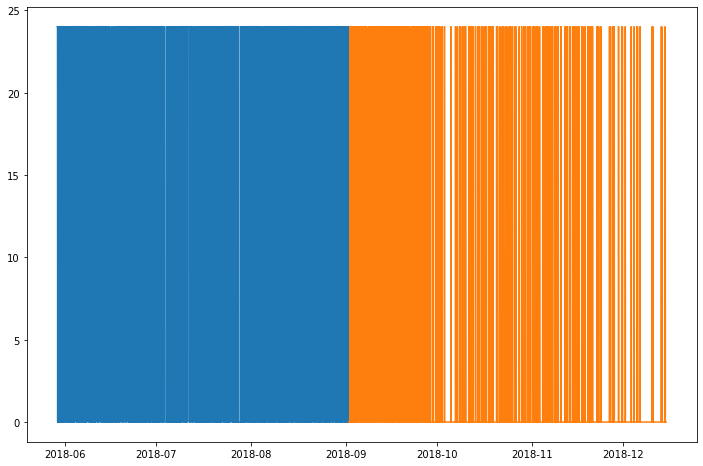

In [76]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(test)
plt.show()

##### SMA - Simple Moving Average

In [77]:
# Calculating the short-window simple moving average
short_rolling = train.rolling(window=12).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(window=24).mean()

##### Plot the 2 window sizes for the SMA

Text(0, 0.5, 'Size (MB)')

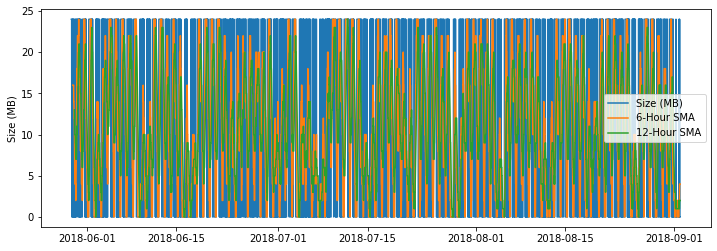

In [78]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

##### Compute the Exponential Moving Average

In [79]:
# Using Pandas to calculate a 2 hour span EMA. 
# adjust=False specifies that we are interested in the 
# recursive calculation mode.
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=24, adjust=False).mean()
ema_long[0:3]

2018-05-29 14:30:00    24.0
2018-05-29 15:00:00    24.0
2018-05-29 15:30:00    24.0
Freq: 30T, Name: cohort, dtype: float64

##### Compare SMA with EMA

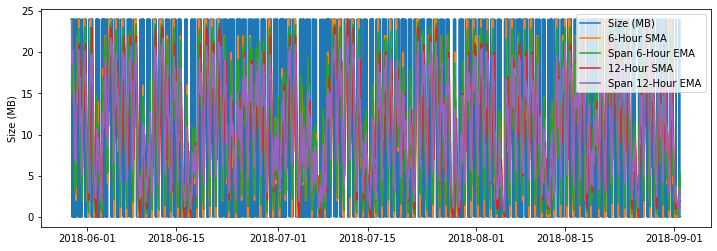

In [80]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '6-Hour SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 6-Hour EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '12-Hour SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 12-Hour EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

yhat = pd.DataFrame(dict(actual=test))

#### Forecast using the EMA

In [81]:
# periods = 24
yhat['moving_avg_forecast'] = ema_long.iloc[-1]

##### Compute the '%b' for each record

In [82]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

q3 = yhat.error.describe().loc['75%']
q1 = yhat.error.describe().loc['25%']

# adding .1 to the IQR so the we don't end up with a denominator of 0. 
ub = q3 + 3*(q3-q1+.1)
lb = q1 - 3*(q3-q1+.1)

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [83]:
# Maggie's code to find outliers:
# span = 24
# ema_long = train.ewm(span=span, adjust=False).mean()
# midband = ema_long[-1]
# ub = midband + ema_long[-24:-1].std()*3
# lb = midband - ema_long[-24:-1].std()*3

# yhat['moving_avg_forecast'] = midband

##### Extract the anomalies

In [84]:
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
2018-09-02 10:30:00,24.0,2.63083,21.36917,36.115283
2018-09-02 13:00:00,24.0,2.63083,21.36917,36.115283
2018-09-02 13:30:00,24.0,2.63083,21.36917,36.115283
2018-09-02 14:00:00,24.0,2.63083,21.36917,36.115283
2018-09-02 14:30:00,24.0,2.63083,21.36917,36.115283
2018-09-02 15:00:00,24.0,2.63083,21.36917,36.115283
2018-09-02 17:00:00,24.0,2.63083,21.36917,36.115283
2018-09-02 18:30:00,24.0,2.63083,21.36917,36.115283
2018-09-02 19:00:00,24.0,2.63083,21.36917,36.115283
2018-09-02 23:30:00,24.0,2.63083,21.36917,36.115283


##### Plot

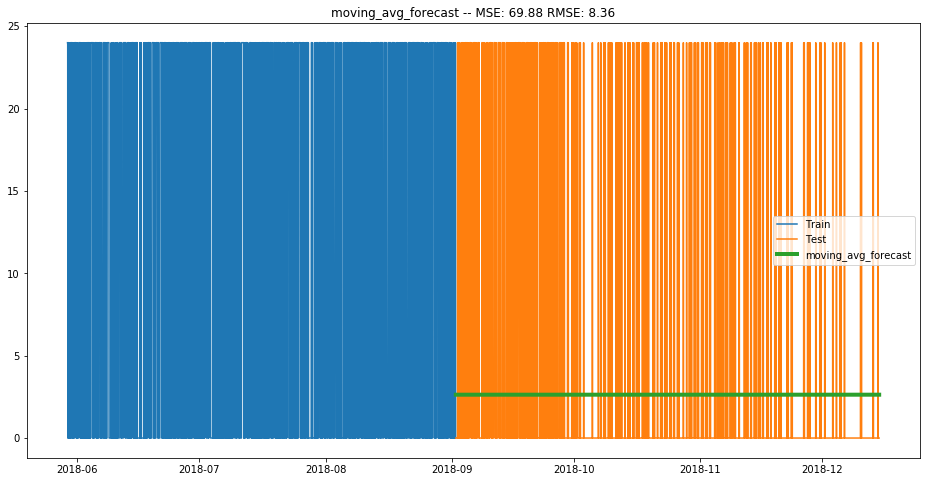

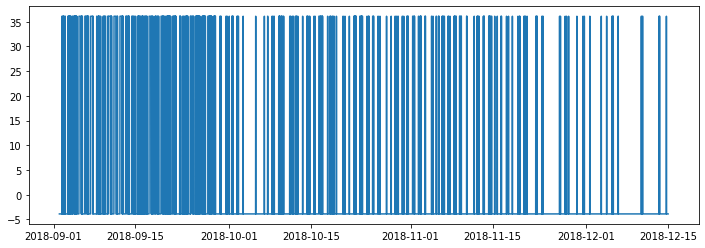

In [85]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)